# Predykcja ataku phishingowego w wiadomości <b>e-mail</b> za pomocą <b><i>nadzorowanego nauczania maszynowego</i></b>
Dataset: 
<ul>
    <li>WSTAWIĆNAZWE</li>
    <ul>
        <li>WSTAWIĆURL</li>
    </ul>
</ul>

### Pobieranie niezbędnych modułów
<ul>
    <li> pandas - praca z <i>Data Framami</i></li>
    <li> numpy - obliczenia</li>
    <li> matplotlib.pyplot - wizualizacja</li>
    <li> sklearn - wszelakie narzędzia do <i>Machine Learningu</i></li>
</ul>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

### Wczytanie uprzednio przygotowanego Data Framu

In [2]:
learning_set = pd.read_csv('ML_DataFrame.csv')
print(learning_set.head())

Unnamed: 0  label  urls_count  protocol  contains_ip  url_length  \
0           0    1.0         1.0       0.0          0.0        21.0   
1           1    1.0         1.0       0.0          0.0        25.0   
2           2    1.0         3.0       0.0          0.0        68.0   
3           3    0.0         3.0       0.0          0.0        14.0   
4           4    1.0         1.0       0.0          0.0       136.0   

   TLD_alpha  subdomain_level  slash_count  dots_count  hyphens_count  \
0        1.0              0.0          3.0         1.0            0.0   
1        1.0              1.0          2.0         2.0            0.0   
2        1.0              1.0          6.0         4.0            0.0   
3        1.0              1.0          0.0         2.0            0.0   
4        1.0              2.0          4.0         4.0            2.0   

   has_non_latin  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [3]:
print(learning_set.isna().sum())
# TODO: naprawić NaN w subdomain level
learning_set.dropna(inplace=True)

Unnamed: 0           0
label                0
urls_count           0
protocol             0
contains_ip          0
url_length           0
TLD_alpha            0
subdomain_level    590
slash_count          0
dots_count           0
hyphens_count        0
has_non_latin        0
dtype: int64


### Wybieranie X i y
X:
<ul>
<li> urls_count </li>
<li>protocol </li>
<li> contains_ip </li>
<li> url_length </li>
<li> TLD_alpha </li>
<li> subdomain_level </li>
<li> slash_count </li>
<li> dots_count </li>
<li> hyphens_count </li>
<li> has_non_latin </li>
</ul>
y:
<ul>
    <li> label </li>
</ul>

In [4]:
X = learning_set.loc[:, 'urls_count':'has_non_latin'].values
y = learning_set.loc[: , 'label'].values
print(X.shape, y.shape)

(41126, 10) (41126,)


### Rozdzielanie X, y na treningowe i testowe zestawy

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(32900, 10) (8226, 10) (32900,) (8226,)


### Szukanie najlepszego <b> n </b> dla <i>KNeighborsClassifier</i>


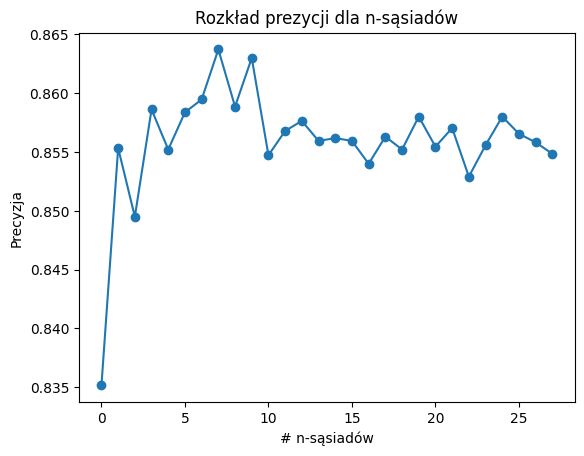

In [7]:
# Nauczanie
n_range = range(2, 30)
scores = []
for n in n_range:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    scores.append(score)

# Wizualizacja
fig, ax = plt.subplots()
values = scores
labels = n_range
ax.plot(values, marker='o')
ax.set_xlabel('# n-sąsiadów')
#ax.set_xticks(n_range) #naprawic oś X
ax.set_ylabel('Precyzja')
ax.set_title('Rozkład prezycji dla n-sąsiadów')

plt.show()

### Szukanie najlepszego modelu

In [8]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=8),
}

results = []
for model in models.values():
    kf = KFold(n_splits=6, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(score)


### Walidacja wybranych modeli

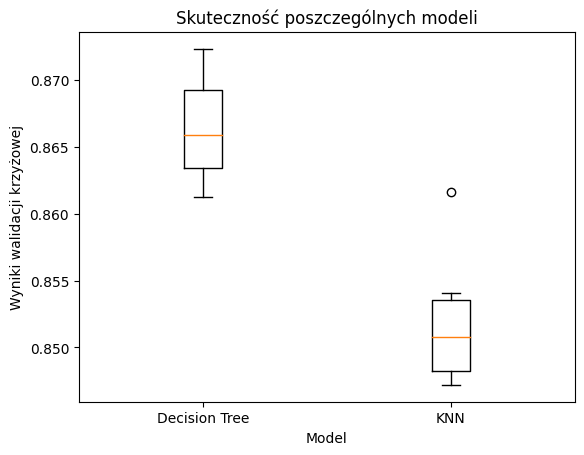

In [9]:
fig, ax = plt.subplots()

ax.boxplot(results, labels=models.keys())
ax.set_title('Skuteczność poszczególnych modeli')
ax.set_xlabel('Model')
ax.set_ylabel('Wyniki walidacji krzyżowej')
plt.show()

In [21]:
tree_std = np.round(results[0].std(), 4)
knn_std = np.round(results[1].std(), 4)
print('Odchylenia standardowe:\n- Decision Tree: {}\n- KNN: {}'.format(tree_std, knn_std))

Odchylenia standardowe:
- Decision Tree: 0.0039
- KNN: 0.0049


### Nauczanie najskuteczniejszego modelu
Najlepszy okazał się <b><i>DecisionTreeClassifier</i></b>
<ul>
    <li>Accuracy ~0.866 (std. ~0.004)</li>
</ul>

In [11]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

### Walidacja modelu

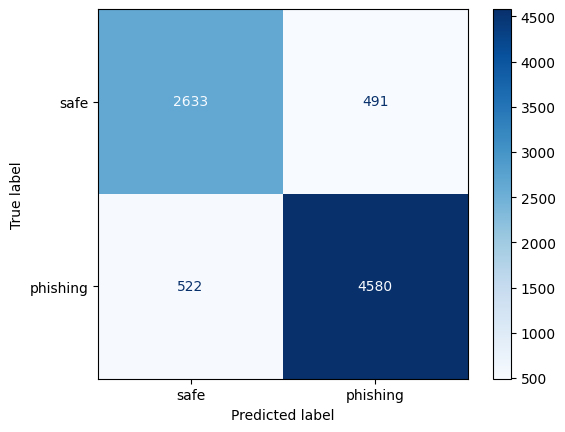

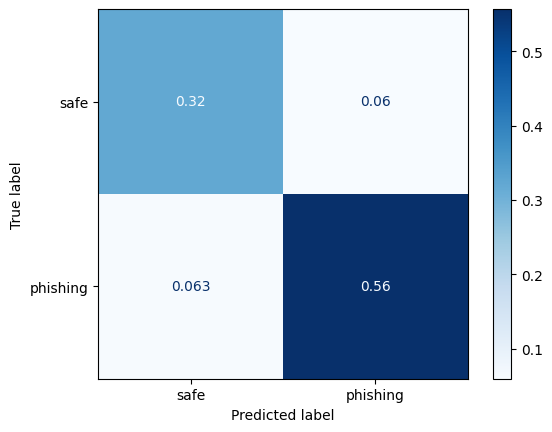

In [19]:
y_pred = tree.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Wartości bezwzględne
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=['safe', 'phishing'])

cm_display.plot(cmap='Blues')
plt.show()

# Wartości względne
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix/np.sum(confusion_matrix),
    display_labels=['safe', 'phishing'])
    
cm_display.plot(cmap='Blues')
plt.show()

In [14]:
target_names = ['safe', 'phishing']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

precision    recall  f1-score   support

        safe       0.83      0.84      0.84      3124
    phishing       0.90      0.90      0.90      5102

    accuracy                           0.88      8226
   macro avg       0.87      0.87      0.87      8226
weighted avg       0.88      0.88      0.88      8226



### Test na przykładzie z żyćka

In [23]:
mail = {
'sender': 'Marcin Sawiński <Marcin.Sawinski@ue.poznan.pl>'
'subject': 'Projekty zaliczeniowe z PSI'
'body': '''
        Drodzy Studenci,

        Chciałbym Was prosić o zapisanie w arkuszu tematów projektów zaliczeniowych oraz wskazanie osób w zespołach (numer teamu            przy nazwisku).

        https://uniekonpoznan.sharepoint.com/:x:/s/AI_2023_2024/EQ5avb31cRpAliTAmGtxQ1gB5_YtB0YJTh3c9t7n30uLdQ?e=yLzaTU

        Pozdrawiam,

        Marcin Sawinski
        --
        Wiadomość wysłana przez system USOS.
        Łączna liczba adresatów tej wiadomości: 117

        Nadawcą korespondencji i jednocześnie administratorem Państwa danych osobowych jest Uniwersytet Ekonomiczny w Poznaniu,             al. Niepodległości 10, 61-875 Poznań, z którym można skontaktować się listownie lub poprzez wiadomość e-mail (rodo@ue.poznan.pl)       Państwa dane osobowe przetwarzane będą w celu prowadzenia niniejszej korespondencji i przez czas jej trwania. Przysługuje           Państwu prawo dostępu do danych, ich sprostowania, ograniczenia przetwarzania, usunięcia, żądania sprzeciwu wobec                   przetwarzania oraz wniesienia skargi do Prezesa Urzędu Ochrony Danych Osobowych. Szczegółowe informacje na temat ochrony            danych osobowych dostępne są w Polityce prywatności.
'''
}
%run scuffed_predictor.ipynb
predict_for(mail=mail)


SyntaxError: invalid syntax (2175827508.py, line 3)

# Rezultat projektu
Przy pomocy <b><i>DecisionTreeClassifier</i></b> udało się wytrenować model z wynikami:
<ul>
    <li> (accuracy) ~     </li>   
    <li> (recall) ~       </li>
    <li> (F1) ~       </li>
</ul>
</br>
Problemy podczas projektu
<ul>
    <li> dostęp do API </li>
    <ul>
        <li> brak sprawdzania domen w blacklistach </li>
        <li> brak sprawdzania adresów e-mail w blacklistach </li>
        <li> słabe/brak informacji o szyfrowaniu SSL </li>
        <li> brak sprawdzania wieku domeny
    </ul>
    <li> Dane zbierane w latach 2008-2022 </li>
    <li> Człowiek minimalnie obeznany w internecie </br>poradziłby sobie z klasyfikowaniem ataków phishingowych z datasetu.

</ul>